# Validity testing

- Models: ensemble average, reliability average, linear regression, delta method, NNGP, CNN
- Depths: l2 depth, linf depth, neighbor depth, 
- Shift: quantile corrected and uncorrected
- Variables: WN, TAS, TASMAX, PR

In [1]:
import os
import gc
import math

# numpy
import numpy as np
import scipy
np.set_printoptions(suppress=True)

# from jax
import jax
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.config import config
import jax.numpy as jnp
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

import haiku as hk
import flax
from flax import linen as nn
import optax

import properscoring as ps

config.update("jax_enable_x64", True)

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
plt.style.use('default')

from matplotlib.gridspec import GridSpec
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from tqdm.notebook import tqdm
from tqdm.notebook import trange

# netCDF
import netCDF4 as nc
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA

In [2]:
def moving_average(a, n=12):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def mse_weighted(x, y):
    nlat = x.shape[1]
    weight = np.cos(np.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
    weight /= np.mean(weight)
    weight = weight[None,:,None]
    
    return np.sqrt(np.mean((x - y)**2 * weight, axis = (1, 2)))

def resize_model(x, dim1, dim2): 
    x = np.moveaxis(x, 0, 2)
    x = resize(x, (dim1, dim2))
    x = np.moveaxis(x, 2, 0)
    return x

def sliced_wasserstein(x, y, w):
    x = x @ w
    y = y @ w
    
    qx = jnp.quantile(x, q = jnp.linspace(0, 1, 100), axis = 0)
    qy = jnp.quantile(y, q = jnp.linspace(0, 1, 100), axis = 0)
    return jnp.mean(jnp.sqrt(jnp.mean((qx - qy)**2, axis = 0)))

sliced_wasserstein = jit(sliced_wasserstein)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logit(x):
    return np.log(x/(1-x))

def softplus(x):
    return np.log(1 + np.exp(x))

def inv_softplus(x):
    return np.log(np.exp(x) - 1)

In [3]:
def width_weighted(x):
    nlat = x.shape[1]
    weight = jnp.cos(np.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
    weight2 = weight/jnp.mean(weight)
    weight2 = weight2[:,None]
    
    width = jnp.max(x, axis = 0) - jnp.min(x, axis = 0)
    return jnp.mean(width * weight2)

width_weighted = jit(width_weighted)

In [4]:
def scale_and_split(xtrain, xtest, model_no, nval = 200, reshape = False):
    ytrain = xtrain[:,model_no]
    ytest = xtest[:,model_no]
    xtrain = np.delete(xtrain, model_no, axis=1)
    xtest = np.delete(xtest, model_no, axis=1)

    ## dimensions
    ntrain = xtrain.shape[0]
    ntest = xtest.shape[0]
    nlat = xtrain.shape[2]
    nlon = xtrain.shape[3]

    ## rescale
    xtrain_mean = np.mean(xtrain, axis = 1)
    xtest_mean = np.mean(xtest, axis = 1)
    xtrain_sd = np.std(xtrain, axis = 1)
    xtest_sd = np.std(xtest, axis = 1)

    xtrain_scaled = (xtrain - xtrain_mean[:,None]) / xtrain_sd[:,None]
    xtest_scaled = (xtest - xtest_mean[:,None]) / xtest_sd[:,None]
    ytrain_scaled = (ytrain - xtrain_mean) / xtrain_sd
    ytest_scaled = (ytest - xtest_mean) / xtest_sd

    ## convert
    if reshape:
        xtrain_scaled = xtrain_scaled.reshape(ntrain, -1)
        xtest_scaled = xtest_scaled.reshape(ntest, -1)
        ytrain_scaled = ytrain_scaled.reshape(ntrain, -1)
        ytest_scaled = ytest_scaled.reshape(ntest, -1)

    xtrain_scaled = jnp.array(xtrain_scaled)
    xtest_scaled = jnp.array(xtest_scaled)
    ytrain_scaled = jnp.array(ytrain_scaled)
    ytest_scaled = jnp.array(ytest_scaled)

    xval_scaled = xtrain_scaled[-nval:]
    yval_scaled = ytrain_scaled[-nval:]
    xtrain_scaled = xtrain_scaled[:-nval]
    ytrain_scaled = ytrain_scaled[:-nval]
    
    return xtrain_scaled, xval_scaled, xtest_scaled, ytrain_scaled, yval_scaled, ytest_scaled

## depths

In [5]:
def inf_depth(y):
    dist = jnp.max(jnp.abs(y), axis = (1, 2))
    return 1/(1 + dist)
inf_depth = jit(inf_depth)

def global_mmd(x, y):
    dist = jnp.max(jnp.abs(x - y), axis = (1, 2))
    dist = jnp.mean(dist)
    return 1/(1 + dist)
global_mmd = jit(vmap(global_mmd, (None, 0)))

def global_mmd_self(x, y):
    dist = jnp.max(jnp.abs(x - y), axis = (1, 2))
    dist = jnp.mean(jnp.sort(dist)[1:])
    return 1/(1 + dist)
global_mmd_self = jit(vmap(global_mmd_self, (None, 0)))

# def tukey_depth(x, y):
#     fx = jnp.mean(x < y, axis = 0)
#     depth = 1 - jnp.abs(1 - 2 * fx)
#     return jnp.mean(depth)
# tukey_depth = jit(vmap(tukey_depth, (None, 0)))

In [6]:
def field_min(x, y):
    return jnp.min(jnp.array([x, y]))
field_min = jit(vmap(vmap(field_min, (0, 0)), (1, 1)))

def tukey_depth(x, y):
    fx_left = jnp.mean(x < y, axis = 0)
    fx_right = jnp.mean(x > y, axis = 0)
    return jnp.mean(2 * field_min(fx_left, fx_right))
tukey_depth = jit(vmap(tukey_depth, (None, 0)))

def tukey_depth_self(x, y):
    fx_left = jnp.sum(x < y, axis = 0)/(x.shape[0] - 1)
    fx_right = jnp.sum(x > y, axis = 0)/(x.shape[0] - 1)
    return jnp.mean(2 * field_min(fx_left, fx_right))
tukey_depth_self = jit(vmap(tukey_depth_self, (None, 0)))

In [7]:
def field_width(x):
    lower = jnp.min(x, axis = 0)
    upper = jnp.max(x, axis = 0)
    lower = jnp.clip(lower, -5, 5)
    upper = jnp.clip(upper, -5, 5)
    return jnp.mean(upper - lower)
field_width = jit(field_width)

## Temperature (TAS)

In [8]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tas_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tas_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tas'

In [9]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
alpha = 0.1

cover1 = np.zeros((nmod, nproj, 8))
cover2 = np.zeros((nmod, nproj, 8))
cover3 = np.zeros((nmod, nproj, 8))

level = np.ceil((1 - alpha) * (nval + 1))/(nval + 1)


for model_no in trange(nmod):
    xtrain, xval, xtest, ytrain, yval, ytest = scale_and_split(xtrain_orig, xtest_orig, model_no = model_no, nval = nval)
    
    for k in trange(nproj, leave = False):
        
        yval_hat = np.load(save_loc + f'/yval_{analysis[k]}_{model_no}.npy')
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}_{model_no}.npy')
        
        if analysis[k] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)
        
        resval = yval - yval_hat.reshape(yval.shape)
        restest = ytest - ytest_hat.reshape(ytest.shape)

        
        dr1a, dr1b = 1-global_mmd_self(resval, resval), 1-global_mmd(resval, restest)
        dr2a, dr2b = 1-inf_depth(resval), 1-inf_depth(restest)
        dr3a, dr3b = 1-tukey_depth_self(resval, resval), 1-tukey_depth(resval, restest)
        
        q1 = np.sort(dr1a)[int(np.ceil((1 - alpha) * (nval + 1)))]
        q2 = np.sort(dr2a)[int(np.ceil((1 - alpha) * (nval + 1)))]
        q3 = np.sort(dr3a)[int(np.ceil((1 - alpha) * (nval + 1)))]
        
        q1 = (q1 + np.quantile(dr1a, level))/2
        q2 = (q2 + np.quantile(dr2a, level))/2
        q3 = (q3 + np.quantile(dr3a, level))/2
        
        cover1[model_no,k] = np.array([np.mean(dr1b[(120*i):(120*(i+1))] < q1) for i in range(8)])
        cover2[model_no,k] = np.array([np.mean(dr2b[(120*i):(120*(i+1))] < q2) for i in range(8)])
        cover3[model_no,k] = np.array([np.mean(dr3b[(120*i):(120*(i+1))] < q3) for i in range(8)])
    

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [10]:
# plt.plot(np.median(cover1, axis = 0).T, c = 'C0')
# plt.plot(np.median(cover2, axis = 0).T, c = 'C1')
# plt.plot(np.median(cover3, axis = 0).T, c = 'C2')

In [11]:
tas_mean_cover1 = np.median(cover1, axis = 0).T
tas_sd_cover1 = np.std(cover1, axis = 0).T/np.sqrt(cover1.shape[0])
tas_lower_cover1 = tas_mean_cover1 - 2 * tas_sd_cover1
tas_upper_cover1 = tas_mean_cover1 + 2 * tas_sd_cover1

tas_mean_cover2 = np.median(cover2, axis = 0).T
tas_sd_cover2 = np.std(cover2, axis = 0).T/np.sqrt(cover2.shape[0])
tas_lower_cover2 = tas_mean_cover2 - 2 * tas_sd_cover2
tas_upper_cover2 = tas_mean_cover2 + 2 * tas_sd_cover2

tas_mean_cover3 = np.median(cover3, axis = 0).T
tas_sd_cover3 = np.std(cover3, axis = 0).T/np.sqrt(cover3.shape[0])
tas_lower_cover3 = tas_mean_cover3 - 2 * tas_sd_cover3
tas_upper_cover3 = tas_mean_cover3 + 2 * tas_sd_cover3

# s = np.arange(8)
# for i in range(nproj):
#     plt.fill_between(s, lower_cover1[:,i], upper_cover1[:,i], alpha = 0.07, color = 'C0')
#     plt.plot(mean_cover1, c = 'C0')
    
#     plt.fill_between(s, lower_cover2[:,i], upper_cover2[:,i], alpha = 0.07, color = 'C1')
#     plt.plot(mean_cover2, c = 'C1')    
    
# #     plt.fill_between(s, lower_cover3[:,i], upper_cover3[:,i], alpha = 0.07, color = 'C3')
# #     plt.plot(mean_cover3, c = 'C3')
    
# plt.axhline(0.9, c='black')
# # # ax[i].set_xticks(s, years, fontsize = 16, rotation=45)

## Temperature max (tmax)

In [12]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tasmax_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tasmax_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tmax'

In [13]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
alpha = 0.1

cover1 = np.zeros((nmod, nproj, 8))
cover2 = np.zeros((nmod, nproj, 8))
cover3 = np.zeros((nmod, nproj, 8))

level = np.ceil((1 - alpha) * (nval + 1))/(nval + 1)


for model_no in trange(nmod):
    xtrain, xval, xtest, ytrain, yval, ytest = scale_and_split(xtrain_orig, xtest_orig, model_no = model_no, nval = nval)
    
    for k in trange(nproj, leave = False):
        
        yval_hat = np.load(save_loc + f'/yval_{analysis[k]}_{model_no}.npy')
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}_{model_no}.npy')
        
        if analysis[k] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)
        
        resval = yval - yval_hat.reshape(yval.shape)
        restest = ytest - ytest_hat.reshape(ytest.shape)

        
        dr1a, dr1b = 1-global_mmd_self(resval, resval), 1-global_mmd(resval, restest)
        dr2a, dr2b = 1-inf_depth(resval), 1-inf_depth(restest)
        dr3a, dr3b = 1-tukey_depth_self(resval, resval), 1-tukey_depth(resval, restest)
        
        q1 = np.sort(dr1a)[int(np.ceil((1 - alpha) * (nval + 1)))]
        q2 = np.sort(dr2a)[int(np.ceil((1 - alpha) * (nval + 1)))]
        q3 = np.sort(dr3a)[int(np.ceil((1 - alpha) * (nval + 1)))]
        
        q1 = (q1 + np.quantile(dr1a, level))/2
        q2 = (q2 + np.quantile(dr2a, level))/2
        q3 = (q3 + np.quantile(dr3a, level))/2
        
        cover1[model_no,k] = np.array([np.mean(dr1b[(120*i):(120*(i+1))] < q1) for i in range(8)])
        cover2[model_no,k] = np.array([np.mean(dr2b[(120*i):(120*(i+1))] < q2) for i in range(8)])
        cover3[model_no,k] = np.array([np.mean(dr3b[(120*i):(120*(i+1))] < q3) for i in range(8)])
    

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [14]:
tmax_mean_cover1 = np.median(cover1, axis = 0).T
tmax_sd_cover1 = np.std(cover1, axis = 0).T/np.sqrt(cover1.shape[0])
tmax_lower_cover1 = tmax_mean_cover1 - 2 * tmax_sd_cover1
tmax_upper_cover1 = tmax_mean_cover1 + 2 * tmax_sd_cover1

tmax_mean_cover2 = np.median(cover2, axis = 0).T
tmax_sd_cover2 = np.std(cover2, axis = 0).T/np.sqrt(cover2.shape[0])
tmax_lower_cover2 = tmax_mean_cover2 - 2 * tmax_sd_cover2
tmax_upper_cover2 = tmax_mean_cover2 + 2 * tmax_sd_cover2

tmax_mean_cover3 = np.median(cover3, axis = 0).T
tmax_sd_cover3 = np.std(cover3, axis = 0).T/np.sqrt(cover3.shape[0])
tmax_lower_cover3 = tmax_mean_cover3 - 2 * tmax_sd_cover3
tmax_upper_cover3 = tmax_mean_cover3 + 2 * tmax_sd_cover3

## Precipitation (pr)

In [15]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_pr_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_pr_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

xtrain_orig = np.log(np.abs(xtrain_orig) + 1e-3)
xtest_orig = np.log(np.abs(xtest_orig) + 1e-3)

save_loc = 'trained_models/pr'

In [16]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
alpha = 0.1

cover1 = np.zeros((nmod, nproj, 8))
cover2 = np.zeros((nmod, nproj, 8))
cover3 = np.zeros((nmod, nproj, 8))

level = np.ceil((1 - alpha) * (nval + 1))/(nval + 1)


for model_no in trange(nmod):
    xtrain, xval, xtest, ytrain, yval, ytest = scale_and_split(xtrain_orig, xtest_orig, model_no = model_no, nval = nval)
    
    for k in trange(nproj, leave = False):
        
        yval_hat = np.load(save_loc + f'/yval_{analysis[k]}_{model_no}.npy')
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}_{model_no}.npy')
        
        if analysis[k] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)
        
        resval = yval - yval_hat.reshape(yval.shape)
        restest = ytest - ytest_hat.reshape(ytest.shape)

        
        dr1a, dr1b = 1-global_mmd_self(resval, resval), 1-global_mmd(resval, restest)
        dr2a, dr2b = 1-inf_depth(resval), 1-inf_depth(restest)
        dr3a, dr3b = 1-tukey_depth_self(resval, resval), 1-tukey_depth(resval, restest)
        
        q1 = np.sort(dr1a)[int(np.ceil((1 - alpha) * (nval + 1)))]
        q2 = np.sort(dr2a)[int(np.ceil((1 - alpha) * (nval + 1)))]
        q3 = np.sort(dr3a)[int(np.ceil((1 - alpha) * (nval + 1)))]
        
        q1 = (q1 + np.quantile(dr1a, level))/2
        q2 = (q2 + np.quantile(dr2a, level))/2
        q3 = (q3 + np.quantile(dr3a, level))/2
        
        cover1[model_no,k] = np.array([np.mean(dr1b[(120*i):(120*(i+1))] < q1) for i in range(8)])
        cover2[model_no,k] = np.array([np.mean(dr2b[(120*i):(120*(i+1))] < q2) for i in range(8)])
        cover3[model_no,k] = np.array([np.mean(dr3b[(120*i):(120*(i+1))] < q3) for i in range(8)])

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
pr_mean_cover1 = np.median(cover1, axis = 0).T
pr_sd_cover1 = np.std(cover1, axis = 0).T/np.sqrt(cover1.shape[0])
pr_lower_cover1 = pr_mean_cover1 - 2 * pr_sd_cover1
pr_upper_cover1 = pr_mean_cover1 + 2 * pr_sd_cover1

pr_mean_cover2 = np.median(cover2, axis = 0).T
pr_sd_cover2 = np.std(cover2, axis = 0).T/np.sqrt(cover2.shape[0])
pr_lower_cover2 = pr_mean_cover2 - 2 * pr_sd_cover2
pr_upper_cover2 = pr_mean_cover2 + 2 * pr_sd_cover2

pr_mean_cover3 = np.median(cover3, axis = 0).T
pr_sd_cover3 = np.std(cover3, axis = 0).T/np.sqrt(cover3.shape[0])
pr_lower_cover3 = pr_mean_cover3 - 2 * pr_sd_cover3
pr_upper_cover3 = pr_mean_cover3 + 2 * pr_sd_cover3

In [18]:
mean_cover1  = [tas_mean_cover1, tmax_mean_cover1, pr_mean_cover1]
sd_cover1    = [tas_sd_cover1, tmax_sd_cover1, pr_sd_cover1]
lower_cover1 = [tas_lower_cover1, tmax_lower_cover1, pr_lower_cover1]
upper_cover1 = [tas_upper_cover1, tmax_upper_cover1, pr_upper_cover1]

mean_cover2  = [tas_mean_cover2, tmax_mean_cover2, pr_mean_cover2]
sd_cover2    = [tas_sd_cover2, tmax_sd_cover2, pr_sd_cover2]
lower_cover2 = [tas_lower_cover2, tmax_lower_cover2, pr_lower_cover2]
upper_cover2 = [tas_upper_cover2, tmax_upper_cover2, pr_upper_cover2]

mean_cover3  = [tas_mean_cover3, tmax_mean_cover3, pr_mean_cover3]
sd_cover3    = [tas_sd_cover3, tmax_sd_cover3, pr_sd_cover3]
lower_cover3 = [tas_lower_cover3, tmax_lower_cover3, pr_lower_cover3]
upper_cover3 = [tas_upper_cover3, tmax_upper_cover3, pr_upper_cover3]

  0%|          | 0/3 [00:00<?, ?it/s]

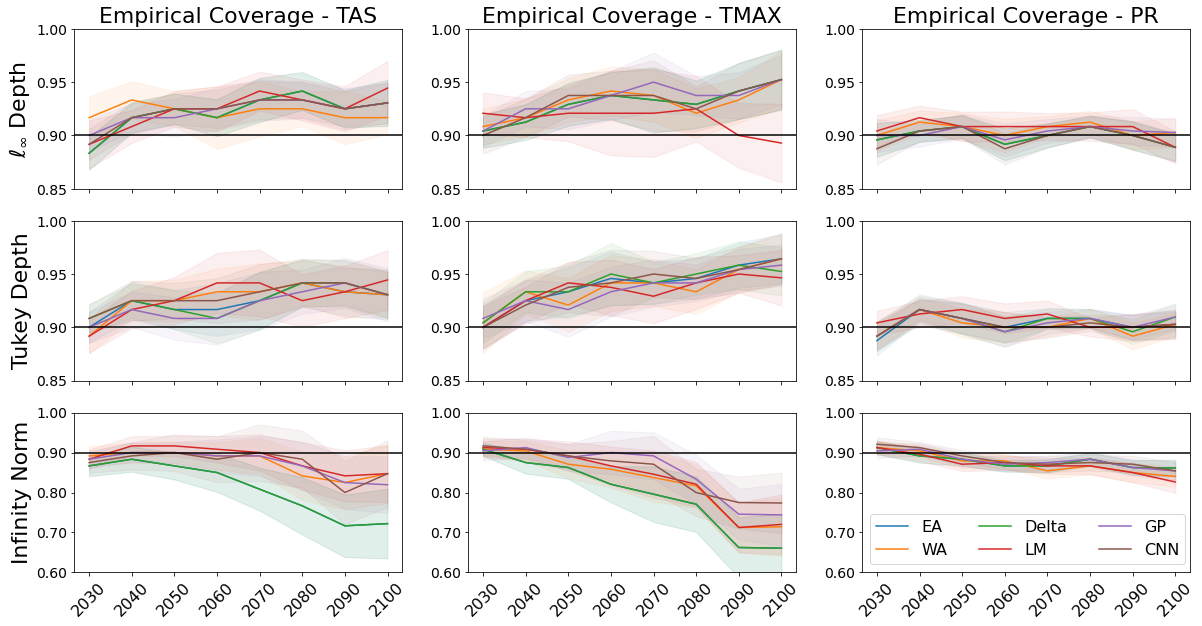

In [37]:
fig = plt.figure(figsize = (20, 10))
gs = GridSpec(3, 3, figure = fig)

plt.rcParams['text.usetex'] = False

s = np.arange(8)
years = np.arange(2030, 2110, 10)
models = ['EA', 'WA', 'Delta', 'LM', 'GP', 'CNN']
for i in trange(3, leave = False):
       
    ## method 1
    ax = plt.subplot(gs[0, i])
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_major_formatter('{x:0<3.2f}')
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_ylim((0.85, 1.0))
    if i == 0: ax.set_ylabel(r'$\ell_{\infty}$ Depth', fontsize = 22)
    
    if i == 0:
        ax.set_title('Empirical Coverage - TAS', fontsize = 22)
    if i == 1:
        ax.set_title('Empirical Coverage - TMAX', fontsize = 22)
    if i == 2:
        ax.set_title('Empirical Coverage - PR', fontsize = 22)
    
    for k in range(nproj):
        ax.fill_between(s, lower_cover1[i][:,k], upper_cover1[i][:,k], alpha = 0.07, color = f'C{k}')
        ax.plot(mean_cover1[i][:,k], c = f'C{k}', label = models[k])
    ax.axhline(0.9, c = 'black')
   
    ## method 2
    ax = plt.subplot(gs[1, i])
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_major_formatter('{x:0<3.2f}')
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_ylim((0.85, 1.0))
    if i == 0: ax.set_ylabel('Tukey Depth', fontsize = 22)
    
    for k in range(nproj):
        ax.fill_between(s, lower_cover2[i][:,k], upper_cover2[i][:,k], alpha = 0.07, color = f'C{k}')
        ax.plot(mean_cover2[i][:,k], c = f'C{k}', label = models[k])
    ax.axhline(0.9, c = 'black')
        
    ## method 3
    ax = plt.subplot(gs[2, i])
    ax.set_xticks(s, years, fontsize = 16, rotation=45)
    ax.yaxis.set_major_formatter('{x:0<3.2f}')
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_ylim((0.6, 1.0))
    if i == 0: ax.set_ylabel('Infinity Norm', fontsize = 22)

    
    for k in range(nproj):
        ax.fill_between(s, lower_cover3[i][:,k], upper_cover3[i][:,k], alpha = 0.07, color = f'C{k}')
        ax.plot(mean_cover3[i][:,k], c = f'C{k}', label = models[k])
    ax.axhline(0.9, c = 'black')
    
ax.legend(fontsize = 16, ncol=3)
plt.show()

In [31]:
wn_cover = np.round(np.vstack([wn_cover1, wn_cover3, wn_cover2]).T.reshape(-1), 3)
tas_cover = np.round(np.vstack([tas_cover1, tas_cover3, tas_cover2]).T.reshape(-1), 3)
tmax_cover = np.round(np.vstack([tmax_cover1, tmax_cover3, tmax_cover2]).T.reshape(-1), 3)
pr_cover = np.round(np.vstack([pr_cover1, pr_cover3, pr_cover2]).T.reshape(-1), 3)
cover = np.vstack([wn_cover, tas_cover, tmax_cover, pr_cover]).T

wn_width = np.round(np.vstack([wn_width1, wn_width3, wn_width2]).T.reshape(-1), 3)
tas_width = np.round(np.vstack([tas_width1, tas_width3, tas_width2]).T.reshape(-1), 3)
tmax_width = np.round(np.vstack([tmax_width1, tmax_width3, tmax_width2]).T.reshape(-1), 3)
pr_width = np.round(np.vstack([pr_width1, pr_width3, pr_width2]).T.reshape(-1), 3)
width = np.vstack([wn_width, tas_width, tmax_width, pr_width]).T

In [78]:
np.set_printoptions(precision=3, floatmode = 'fixed')
table = np.hstack([cover, width])

In [79]:
for row in table:
    x = [f"{i:1.3f}" for i in row]
    print(' & '.join(x))

0.902 & 0.890 & 0.893 & 0.906 & 6.126 & 3.717 & 3.532 & 2.611
0.900 & 0.928 & 0.929 & 0.929 & 6.100 & 3.717 & 3.534 & 2.617
0.901 & 0.870 & 0.831 & 0.906 & 6.120 & 3.705 & 3.524 & 2.612
0.900 & 0.921 & 0.922 & 0.910 & 6.220 & 3.563 & 3.474 & 2.884
0.900 & 0.967 & 0.964 & 0.938 & 6.195 & 3.563 & 3.472 & 2.887
0.901 & 0.933 & 0.925 & 0.920 & 6.213 & 3.562 & 3.474 & 2.885
0.902 & 0.890 & 0.893 & 0.906 & 6.126 & 3.731 & 3.605 & 2.871
0.900 & 0.928 & 0.929 & 0.929 & 6.100 & 3.731 & 3.605 & 2.877
0.900 & 0.904 & 0.893 & 0.906 & 6.120 & 3.730 & 3.604 & 2.872
0.902 & 0.900 & 0.913 & 0.912 & 6.323 & 5.341 & 4.831 & 3.121
0.903 & 0.975 & 0.969 & 0.945 & 6.330 & 5.346 & 4.837 & 3.128
0.901 & 0.874 & 0.868 & 0.903 & 6.332 & 5.328 & 4.816 & 3.119
0.902 & 0.932 & 0.933 & 0.908 & 6.126 & 3.376 & 3.295 & 2.805
0.900 & 0.977 & 0.975 & 0.949 & 6.100 & 3.375 & 3.293 & 2.809
0.900 & 0.931 & 0.926 & 0.916 & 6.120 & 3.374 & 3.295 & 2.806
0.900 & 0.876 & 0.856 & 0.901 & 6.353 & 3.686 & 3.646 & 2.952
0.905 & 

In [82]:
analysis = ['EA', 'WA', 'Delta', 'LM', 'GP', 'CNN']
for i, row in enumerate(table):
    x = [f"{i:1.3f}" for i in row]
    print(analysis[i//3], '\t', ' & '.join(x))

EA 	 0.902 & 0.890 & 0.893 & 0.906 & 6.126 & 3.717 & 3.532 & 2.611
EA 	 0.900 & 0.928 & 0.929 & 0.929 & 6.100 & 3.717 & 3.534 & 2.617
EA 	 0.901 & 0.870 & 0.831 & 0.906 & 6.120 & 3.705 & 3.524 & 2.612
WA 	 0.900 & 0.921 & 0.922 & 0.910 & 6.220 & 3.563 & 3.474 & 2.884
WA 	 0.900 & 0.967 & 0.964 & 0.938 & 6.195 & 3.563 & 3.472 & 2.887
WA 	 0.901 & 0.933 & 0.925 & 0.920 & 6.213 & 3.562 & 3.474 & 2.885
Delta 	 0.902 & 0.890 & 0.893 & 0.906 & 6.126 & 3.731 & 3.605 & 2.871
Delta 	 0.900 & 0.928 & 0.929 & 0.929 & 6.100 & 3.731 & 3.605 & 2.877
Delta 	 0.900 & 0.904 & 0.893 & 0.906 & 6.120 & 3.730 & 3.604 & 2.872
LM 	 0.902 & 0.900 & 0.913 & 0.912 & 6.323 & 5.341 & 4.831 & 3.121
LM 	 0.903 & 0.975 & 0.969 & 0.945 & 6.330 & 5.346 & 4.837 & 3.128
LM 	 0.901 & 0.874 & 0.868 & 0.903 & 6.332 & 5.328 & 4.816 & 3.119
GP 	 0.902 & 0.932 & 0.933 & 0.908 & 6.126 & 3.376 & 3.295 & 2.805
GP 	 0.900 & 0.977 & 0.975 & 0.949 & 6.100 & 3.375 & 3.293 & 2.809
GP 	 0.900 & 0.931 & 0.926 & 0.916 & 6.120 & 3.374 & 